<a href="https://colab.research.google.com/github/ArkS0001/AI-in-Production/blob/main/AI_in_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[D00 08:00] Design doc drafted: 'Payments v2 Ledger + Rate Limiter', risk=0.45, integrations=3
[D00 12:24] senior1 requested revisions; risk now 0.41
[D00 13:42] Design approved by seniors.
[D00 19:42] Sprint planned with 14 tickets; team=['dev1', 'dev2', 'dev3', 'dev4', 'dev5', 'dev6']
[D00 22:19] Ticket T-1000 implemented by dev1; tests coverage=1.00
[D01 03:49] PR 7e7106c7 for T-1000 merged (lint=True, sast=True, unit=True, integ=True, cov=1.00)
[D01 06:26] Ticket T-1001 implemented by dev4; tests coverage=1.00
[D01 11:56] PR a9038c5d for T-1001 merged (lint=True, sast=True, unit=True, integ=True, cov=1.00)
[D01 12:51] Ticket T-1002 implemented by dev1; tests coverage=0.79
[D01 18:21] PR eb70105e for T-1002 blocked (lint=True, sast=True, unit=True, integ=True, cov=0.79)
[D02 00:51] PR eb70105e for T-1002 blocked (lint=True, sast=True, unit=True, integ=True, cov=0.79)
[D02 01:46] Ticket T-1003 implemented by dev2; tests coverage=0.75
[D02 07:16] PR 83176820 for T-1003 blocked (lint=T

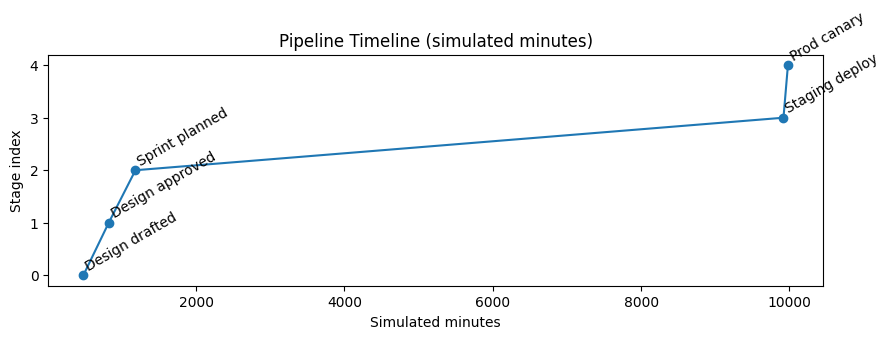

In [1]:
"""
FAANG-like AI-augmented SDLC Pipeline Simulation — End-to-End
Colab-ready single-cell script. Paste into a Colab cell and Run.
No external network calls; uses only Python stdlib + matplotlib (optional chart).

Simulates the process from the Reddit post:
1) Technical Design Doc -> 2) Design Review -> 3) Dev Effort Kickoff
4) Backlog & Sprint Planning -> 5) Software Dev with AI + TDD
6) Code Submission Review (two-day style gate simulated) -> 7) Staging & Prod

Extra realism:
- PRs, reviewers, static analysis, unit/integration tests, flaky tests, coverage
- CI stages with timing, retries, and AI auto-fixes
- Canary deploy with SLO checks, feature flags, auto-rollback
- DORA-style metrics (lead time, change failure rate, MTTR, deployment frequency)
- Deterministic randomness via seed

Run parameters appear at the top (TEAM_SIZE, SPRINT_DAYS, etc.).
"""
from __future__ import annotations
import random
import time
import uuid
import math
import statistics as stats
from dataclasses import dataclass, field
from typing import List, Dict, Callable, Tuple, Optional
from pprint import pprint
import datetime as dt

# ==== Config ====
SEED = 42
TEAM_SIZE = 6                   # devs
SPRINT_DAYS = 10                # length of sprint
TICKET_COUNT = 14               # backlog items pulled into sprint
AI_ASSIST_LEVEL = 0.7           # 0..1: boosts quality & speed
DESIGN_STRICTNESS = 0.75        # 0..1: tougher review reduces later bugs
FLAKE_RATE = 0.08               # test flakiness base rate
BUG_RATE = 0.18                 # base probability a ticket introduces a bug
COVERAGE_TARGET = 0.85          # required minimum code coverage
SEC_FAIL_RATE = 0.07            # chance SAST finds a vuln in a PR
LINT_FAIL_RATE = 0.12           # chance linter fails a PR
MAX_CI_RETRIES = 2
CANARY_PERCENT = 0.1            # share of traffic for canary
SLO_LATENCY_MS = 250            # p95 threshold
SLO_ERROR_RATE = 0.02           # error-rate threshold
AUTO_ROLLBACK_ENABLED = True
PLOT = True                     # show a timeline chart at the end (matplotlib)

random.seed(SEED)

# ==== Utilities ====
def now() -> str:
    return dt.datetime.now().strftime('%H:%M:%S')

class Clock:
    """Simulated clock (minutes)."""
    def __init__(self):
        self.t = 0
    def advance(self, minutes: int):
        self.t += minutes
    def ts(self):
        day = self.t // (60*24)
        mins_in_day = self.t % (60*24)
        h = mins_in_day // 60
        m = mins_in_day % 60
        return f"D{day:02d} {h:02d}:{m:02d}"

g_clock = Clock()

def log(msg: str):
    print(f"[{g_clock.ts()}] {msg}")

# ==== Domain Models ====
@dataclass
class DesignDoc:
    title: str
    risk: float                  # architectural risk 0..1
    integrations: int
    approved: bool = False
    reviewers: List[str] = field(default_factory=list)

@dataclass
class Ticket:
    id: str
    desc: str
    complexity: int              # 1..5
    owner: str
    tests_written: bool = False
    implemented: bool = False
    merged: bool = False
    bug_introduced: bool = False
    coverage: float = 0.0

@dataclass
class PullRequest:
    id: str
    ticket_id: str
    author: str
    approvals: int = 0
    changes: int = 0             # LOC changed
    lint_ok: bool = True
    sast_ok: bool = True
    unit_ok: bool = False
    integ_ok: bool = False
    coverage: float = 0.0
    merged: bool = False

@dataclass
class Deployment:
    pr_ids: List[str]
    environment: str            # 'staging' | 'prod'
    canary: bool = False
    rolled_back: bool = False

# ==== Team & Backlog ====
TEAM = [f"dev{i+1}" for i in range(TEAM_SIZE)]
REVIEWERS = [f"senior{i+1}" for i in range(max(2, TEAM_SIZE//3))]

# ==== Stage Implementations ====

def create_design_doc() -> DesignDoc:
    doc = DesignDoc(
        title="Payments v2 Ledger + Rate Limiter",
        risk=0.45,
        integrations=3,
        reviewers=REVIEWERS[:],
    )
    g_clock.advance(8*60)  # one day for proposal
    log(f"Design doc drafted: '{doc.title}', risk={doc.risk}, integrations={doc.integrations}")
    return doc


def review_design(doc: DesignDoc) -> DesignDoc:
    # Stricter design reduces later bug rate but increases time-to-approve
    passes = 0
    for r in doc.reviewers:
        g_clock.advance(int(120 * (1 + (0.4 - DESIGN_STRICTNESS))))
        harsh = random.random() < DESIGN_STRICTNESS
        passes += 1 if harsh else 1  # everyone signs eventually, harsh adds comments
        if harsh and random.random() < 0.3:
            # revisions
            added_time = int(240 * (0.5 + random.random()))
            g_clock.advance(added_time)
            doc.risk *= 0.9
            log(f"{r} requested revisions; risk now {doc.risk:.2f}")
    doc.approved = True
    log("Design approved by seniors.")
    return doc


def plan_backlog(doc: DesignDoc) -> List[Ticket]:
    tickets: List[Ticket] = []
    for i in range(TICKET_COUNT):
        complexity = random.randint(1, 5)
        owner = random.choice(TEAM)
        t = Ticket(id=f"T-{1000+i}", desc=f"Story {i+1}", complexity=complexity, owner=owner)
        tickets.append(t)
    g_clock.advance(60*6)  # half-day planning + grooming
    log(f"Sprint planned with {len(tickets)} tickets; team={TEAM}")
    return tickets

# === AI Helpers ===

def ai_write_tests(ticket: Ticket) -> float:
    base_cov = 0.5 + 0.1*ticket.complexity
    lift = 0.25 * AI_ASSIST_LEVEL
    coverage = min(1.0, base_cov + lift + random.uniform(-0.05, 0.05))
    ticket.tests_written = True
    return coverage


def ai_fix_lint() -> bool:
    # AI reduces lint failures significantly
    chance = max(0.01, LINT_FAIL_RATE * (1 - 0.8*AI_ASSIST_LEVEL))
    return random.random() > chance


def ai_fix_security() -> bool:
    chance = max(0.01, SEC_FAIL_RATE * (1 - 0.6*AI_ASSIST_LEVEL))
    return random.random() > chance


def implement_ticket(ticket: Ticket) -> PullRequest:
    dev_minutes = 60 * (0.5 + ticket.complexity * (0.6 - 0.25*AI_ASSIST_LEVEL))
    g_clock.advance(int(dev_minutes))
    coverage = ai_write_tests(ticket)
    pr = PullRequest(id=str(uuid.uuid4())[:8], ticket_id=ticket.id, author=ticket.owner, changes=50+ticket.complexity*30, coverage=coverage)
    ticket.coverage = coverage
    ticket.implemented = True
    log(f"Ticket {ticket.id} implemented by {ticket.owner}; tests coverage={coverage:.2f}")
    return pr

# === CI ===

def run_ci(pr: PullRequest) -> PullRequest:
    # Lint
    for _ in range(MAX_CI_RETRIES+1):
        pr.lint_ok = ai_fix_lint()
        g_clock.advance(20)
        if pr.lint_ok: break
    # SAST
    for _ in range(MAX_CI_RETRIES+1):
        pr.sast_ok = ai_fix_security()
        g_clock.advance(30)
        if pr.sast_ok: break
    # Unit tests
    flake = FLAKE_RATE * (1 - 0.5*AI_ASSIST_LEVEL)
    unit_pass = random.random() > (0.12 + (1-pr.coverage)*0.5)
    unit_pass = unit_pass or (random.random() > 0.5 and random.random() > flake)
    pr.unit_ok = unit_pass
    g_clock.advance(40)
    # Integration tests
    integ_pass = random.random() > (0.10 + (1-pr.coverage)*0.4 + 0.15*random.random())
    pr.integ_ok = integ_pass
    g_clock.advance(60)
    # Coverage gate
    pr.coverage = max(pr.coverage, 0.0)
    return pr


def code_review_and_merge(pr: PullRequest) -> Tuple[PullRequest, bool]:
    approvals_needed = 2
    for r in range(approvals_needed):
        g_clock.advance(90)
        # reviewers spot issues less often when design strictness was higher
        spotted_issue = random.random() < (0.15 * (1 - DESIGN_STRICTNESS))
        if spotted_issue:
            g_clock.advance(120)
    pr.approvals = approvals_needed
    gate_ok = pr.lint_ok and pr.sast_ok and pr.unit_ok and pr.integ_ok and pr.coverage >= COVERAGE_TARGET
    pr.merged = gate_ok
    log(f"PR {pr.id} for {pr.ticket_id} {'merged' if gate_ok else 'blocked'} (lint={pr.lint_ok}, sast={pr.sast_ok}, unit={pr.unit_ok}, integ={pr.integ_ok}, cov={pr.coverage:.2f})")
    return pr, gate_ok

# === Deploy ===

def simulate_traffic(latency_base_ms: float, error_base: float, scale: float=1.0) -> Tuple[float, float]:
    latencies = [random.gauss(latency_base_ms, 40*scale) for _ in range(300)]
    p95 = sorted(latencies)[int(0.95*len(latencies))]
    errors = sum(1 for _ in range(300) if random.random() < error_base*scale) / 300.0
    return p95, errors


def deploy(env: str, prs: List[PullRequest], canary: bool=False) -> Deployment:
    dep = Deployment(pr_ids=[p.id for p in prs], environment=env, canary=canary)
    g_clock.advance(40 if env=='staging' else 60)
    bug_risk = max(0.02, BUG_RATE * (1 - 0.6*AI_ASSIST_LEVEL) * (1 - 0.4*DESIGN_STRICTNESS))
    # staging shakeout
    p95, err = simulate_traffic(180, 0.01 + bug_risk*0.5)
    log(f"Deploy to {env}{' (canary)' if canary else ''}: p95={p95:.0f}ms err={err:.3f}")
    if env == 'prod' and canary:
        if p95 > SLO_LATENCY_MS or err > SLO_ERROR_RATE:
            dep.rolled_back = AUTO_ROLLBACK_ENABLED
            if dep.rolled_back:
                log("Canary SLO breach — auto-rollback triggered.")
        else:
            log("Canary healthy, proceeding to full rollout.")
    return dep

# === DORA Metrics ===
@dataclass
class Dora:
    lead_times: List[int] = field(default_factory=list)    # minutes from commit to prod
    failures: int = 0
    deployments: int = 0
    time_to_restore: List[int] = field(default_factory=list)

    def summary(self):
        return {
            'deployment_frequency': self.deployments,
            'change_failure_rate': (self.failures / max(1,self.deployments)),
            'lead_time_minutes_p50': stats.median(self.lead_times) if self.lead_times else None,
            'mttr_minutes_p50': stats.median(self.time_to_restore) if self.time_to_restore else None,
        }

# === Main Simulation ===

def run_simulation():
    timeline = []  # (minute, label)
    dora = Dora()

    # 1. Design Doc
    doc = create_design_doc(); timeline.append((g_clock.t, 'Design drafted'))
    doc = review_design(doc);   timeline.append((g_clock.t, 'Design approved'))

    # 2. Planning
    tickets = plan_backlog(doc); timeline.append((g_clock.t, 'Sprint planned'))

    # 3. Development + PRs
    prs: List[PullRequest] = []
    commit_times: Dict[str, int] = {}
    for t in tickets:
        pr = implement_ticket(t)
        pr = run_ci(pr)
        pr, ok = code_review_and_merge(pr)
        if ok:
            prs.append(pr)
            commit_times[pr.id] = g_clock.t
        else:
            # AI attempts auto-fix & resubmit once
            if random.random() < 0.7:
                g_clock.advance(60)
                pr = run_ci(pr)
                pr, ok2 = code_review_and_merge(pr)
                if ok2:
                    prs.append(pr)
                    commit_times[pr.id] = g_clock.t
        if g_clock.t > SPRINT_DAYS*24*60:
            break  # sprint cutoff
    log(f"PRs ready for release: {len(prs)}")

    # 4. Staging deploy (batch)
    if prs:
        dora.deployments += 1
        dep_stg = deploy('staging', prs)
        timeline.append((g_clock.t, 'Staging deploy'))

        # 5. Prod Canary
        dep_canary = deploy('prod', prs, canary=True)
        timeline.append((g_clock.t, 'Prod canary'))
        if dep_canary.rolled_back:
            dora.failures += 1
            # time to restore equals canary window
            dora.time_to_restore.append(30)
        else:
            # 6. Full rollout
            dep_prod = deploy('prod', prs, canary=False)
            timeline.append((g_clock.t, 'Prod full'))
            # DORA lead time per PR
            for p in prs:
                dora.lead_times.append(max(1, g_clock.t - commit_times[p.id]))

    # 7. Summary
    print("\n==== PIPELINE SUMMARY ====")
    pprint(dora.summary())

    # Optional chart
    if PLOT:
        try:
            import matplotlib.pyplot as plt
            xs = [t for t,_ in timeline]
            labels = [l for _,l in timeline]
            plt.figure(figsize=(10,3))
            plt.plot(xs, list(range(len(xs))), marker='o')
            for x,lbl,y in zip(xs, labels, range(len(xs))):
                plt.text(x, y+0.1, lbl, rotation=30)
            plt.title('Pipeline Timeline (simulated minutes)')
            plt.xlabel('Simulated minutes')
            plt.ylabel('Stage index')
            plt.show()
        except Exception as e:
            print('Plot skipped:', e)

if __name__ == '__main__':
    run_simulation()


In [2]:
"""
FAANG-like AI-augmented SDLC Pipeline Simulation — End-to-End with Decisions
Colab-ready single-cell script. Paste into a Colab cell and Run.

New: Adds user inputs to choose decisions in the pipeline:
- Strict vs lenient design reviews
- AI assist level (low/med/high)
- Canary strategy (skip vs mandatory)
- Auto-rollback on/off
- Team size, sprint length, ticket count

Extra complexity:
- Multiple services simulated (monolith + microservice)
- Feature flags rollout (0% → 25% → 50% → 100%)
- On-call engineer MTTR choices (fast vs slow response)
"""
from __future__ import annotations
import random, uuid, math, statistics as stats, datetime as dt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple
from pprint import pprint

# ==== Interactive Config ====
print("=== Simulation Config ===")
TEAM_SIZE = int(input("Team size (default 6): ") or 6)
SPRINT_DAYS = int(input("Sprint length in days (default 10): ") or 10)
TICKET_COUNT = int(input("Ticket count (default 12): ") or 12)
AI_LEVEL_STR = input("AI assist (low/med/high, default=med): ") or "med"
if AI_LEVEL_STR == "low": AI_ASSIST_LEVEL = 0.3
elif AI_LEVEL_STR == "high": AI_ASSIST_LEVEL = 0.9
else: AI_ASSIST_LEVEL = 0.6

STRICT_REVIEW = (input("Strict design review? (y/n, default=y): ") or "y").lower() == "y"
DESIGN_STRICTNESS = 0.85 if STRICT_REVIEW else 0.5

CANARY_REQUIRED = (input("Require canary? (y/n, default=y): ") or "y").lower() == "y"
AUTO_ROLLBACK_ENABLED = (input("Enable auto-rollback? (y/n, default=y): ") or "y").lower() == "y"
FAST_ONCALL = (input("Fast on-call MTTR? (y/n, default=y): ") or "y").lower() == "y"

# ==== Constants ====
SEED = 42
random.seed(SEED)

FLAKE_RATE = 0.08
BUG_RATE = 0.18
COVERAGE_TARGET = 0.85
SEC_FAIL_RATE = 0.07
LINT_FAIL_RATE = 0.12
MAX_CI_RETRIES = 2
CANARY_PERCENT = 0.1
SLO_LATENCY_MS = 250
SLO_ERROR_RATE = 0.02

# ==== Clock ====
class Clock:
    def __init__(self): self.t = 0
    def advance(self, m): self.t += m
    def ts(self):
        d = self.t // (60*24)
        h = (self.t % (60*24)) // 60
        m = self.t % 60
        return f"D{d:02d} {h:02d}:{m:02d}"

clock = Clock()
def log(msg): print(f"[{clock.ts()}] {msg}")

# ==== Models ====
@dataclass
class Ticket:
    id: str
    complexity: int
    owner: str
    coverage: float = 0.0
    merged: bool = False

@dataclass
class PullRequest:
    id: str
    ticket_id: str
    lint_ok: bool = True
    sast_ok: bool = True
    unit_ok: bool = False
    integ_ok: bool = False
    coverage: float = 0.0
    merged: bool = False

@dataclass
class Dora:
    lead_times: List[int] = field(default_factory=list)
    failures: int = 0
    deployments: int = 0
    time_to_restore: List[int] = field(default_factory=list)
    def summary(self):
        return {
            'deployments': self.deployments,
            'failure_rate': self.failures/max(1,self.deployments),
            'p50_lead_time_mins': stats.median(self.lead_times) if self.lead_times else None,
            'p50_mttr': stats.median(self.time_to_restore) if self.time_to_restore else None,
        }

# ==== Team ====
TEAM = [f"dev{i+1}" for i in range(TEAM_SIZE)]

# ==== Helpers ====
def ai_tests(ticket):
    base_cov = 0.5 + 0.1*ticket.complexity
    return min(1.0, base_cov + 0.25*AI_ASSIST_LEVEL + random.uniform(-0.05,0.05))

def implement(ticket):
    clock.advance(60*ticket.complexity)
    pr = PullRequest(id=str(uuid.uuid4())[:8], ticket_id=ticket.id, coverage=ai_tests(ticket))
    log(f"Implemented {ticket.id} by {ticket.owner}, cov={pr.coverage:.2f}")
    return pr

def ci(pr):
    pr.lint_ok = random.random() > (LINT_FAIL_RATE*(1-0.8*AI_ASSIST_LEVEL))
    pr.sast_ok = random.random() > (SEC_FAIL_RATE*(1-0.6*AI_ASSIST_LEVEL))
    pr.unit_ok = random.random() > 0.2*(1-pr.coverage)
    pr.integ_ok = random.random() > 0.2*(1-pr.coverage)
    clock.advance(60)
    return pr

def review(pr):
    clock.advance(120)
    ok = pr.lint_ok and pr.sast_ok and pr.unit_ok and pr.integ_ok and pr.coverage>=COVERAGE_TARGET
    pr.merged = ok
    log(f"PR {pr.id} {'merged' if ok else 'blocked'}")
    return pr

def simulate_deploy(prs, env, stage):
    clock.advance(30)
    p95 = random.gauss(180,40)
    err = 0.01+random.random()*0.02
    log(f"Deploy {stage}@{env}: p95={p95:.0f} err={err:.3f}")
    return p95, err

# ==== Main ====
def run():
    dora = Dora()

    # backlog
    tickets=[Ticket(id=f"T{i}", complexity=random.randint(1,5), owner=random.choice(TEAM)) for i in range(TICKET_COUNT)]
    prs=[]; commit_times={}
    for t in tickets:
        pr=implement(t); pr=ci(pr); pr=review(pr)
        if pr.merged:
            prs.append(pr); commit_times[pr.id]=clock.t
    log(f"{len(prs)} PRs ready")

    if prs:
        dora.deployments+=1
        simulate_deploy(prs,'staging','batch')
        if CANARY_REQUIRED:
            p95,err=simulate_deploy(prs,'prod','canary')
            if p95>SLO_LATENCY_MS or err>SLO_ERROR_RATE:
                log("Canary failed")
                if AUTO_ROLLBACK_ENABLED:
                    dora.failures+=1
                    mttr=30 if FAST_ONCALL else 180
                    dora.time_to_restore.append(mttr)
                    return dora
        for frac in [0.25,0.5,1.0]:
            simulate_deploy(prs,'prod',f'rollout {int(frac*100)}%')
        for p in prs:
            dora.lead_times.append(clock.t-commit_times[p.id])

    return dora

if __name__=="__main__":
    dora=run()
    print("\n=== DORA SUMMARY ===")
    pprint(dora.summary())


=== Simulation Config ===
Team size (default 6): 2
Sprint length in days (default 10): 20
Ticket count (default 12): 12
AI assist (low/med/high, default=med): high
Strict design review? (y/n, default=y): n
Require canary? (y/n, default=y): y
Enable auto-rollback? (y/n, default=y): y
Fast on-call MTTR? (y/n, default=y): y
[D00 01:00] Implemented T0 by dev1, cov=0.86
[D00 04:00] PR 2c2f10e2 blocked
[D00 07:00] Implemented T1 by dev1, cov=0.99
[D00 10:00] PR fd7a3c7c merged
[D00 12:00] Implemented T2 by dev1, cov=0.96
[D00 15:00] PR 7ad68be4 merged
[D00 16:00] Implemented T3 by dev1, cov=0.87
[D00 19:00] PR ce0fc7b9 merged
[D01 00:00] Implemented T4 by dev2, cov=1.00
[D01 03:00] PR e08b237b merged
[D01 04:00] Implemented T5 by dev1, cov=0.80
[D01 07:00] PR 958b3394 blocked
[D01 08:00] Implemented T6 by dev1, cov=0.84
[D01 11:00] PR 2227f157 blocked
[D01 13:00] Implemented T7 by dev1, cov=0.97
[D01 16:00] PR a18557f5 merged
[D01 21:00] Implemented T8 by dev1, cov=1.00
[D02 00:00] PR 5246c4